<a href="https://colab.research.google.com/github/PMartey/KaggleX-Project/blob/main/001_Updated_Copy_of_Stock_trading_and_Insurance_Bot_KaggleX_QA_with_Gemma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [2]:
# Download the gemma_2b_en/2 from kaggle

keras_gemma_keras_gemma_2b_en_2_path = kagglehub.model_download('keras/gemma/Keras/gemma_2b_en/2')
#keras_gemma_keras_gemma_instruct_2b_en_2_path = kagglehub.model_download('keras/gemma/Keras/gemma_instruct_2b_en/2')
#keras_gemma_keras_gemma_instruct_7b_en_2_path = kagglehub.model_download('keras/gemma/Keras/gemma_instruct_7b_en/2')
#keras_gemma_keras_gemma_7b_en_2_path = kagglehub.model_download('keras/gemma/Keras/gemma_7b_en/2')

#print('Data source import complete.')

# Google – AI Assistants for Data Tasks with Gemma with [KerasNLP](https://github.com/keras-team/keras-nlp) and [Keras](https://github.com/keras-team/keras)

> The objective of this question and answer model is to build a chatbot to assist individuals in understanding stock trading concepts or answering day to day insurance or stock trading questions

<div align="center">
    <img src="https://thumbs.dreamstime.com/z/financial-money-business-diagram-report-52108082.jpg?ct=jpeg">
</div>

In this project, we will create a notebook that demonstrate how to use the Gemma LLM to accomplish one or more of the following  tasks:
1. **<font color="red">Answer common questions about insurance or trades.</font>**
2. Explain or teach basic trading/insurance concepts.
3. Summarize Solution write-ups.
4. Give insurance market estimates.
5. Answer common questions about what is going on in the stock market.

This notebook guides you through performing `"1. Answer common questions about insurance or trades"` task for the project. As this task requires specific knowledge of the financial markets(banking,stocks,insurance,and shares), we need precise information about Finance. To do so, I have created a dataset, ["Final Training Dataset"], collecting data from [huggingface.com](https://huggingface.co/datasets/yymYYM/stock_trading_QA). To make things easier for the model, the data is curated to have Question-Answer pair format. We will use this dataset to fine-tune **Gemma LLM** to answer questions about stcok trading.

<u>Fun fact</u>: This notebook is backend-agnostic, supporting TensorFlow, PyTorch, and JAX. However, the best performance can be achieved from `JAX`. Utilizing KerasNLP and Keras allows us to choose our preferred backend. Explore more details on [Keras](https://keras.io/keras_3/).

**Note**: For a more in-depth understanding of KerasNLP, refer to the [KerasNLP guides](https://keras.io/keras_nlp/).

# Install Libraries

In [3]:
# Install Keras 3 last. See https://keras.io/getting_started/ for more details.
!pip install -q -U keras-nlp
!pip install -q -U keras>=3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.1/644.1 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 101.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


# Import Libraries

In [4]:
import os
os.environ["KERAS_BACKEND"] = "jax" # you can also use tensorflow or torch
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00" # avoid memory fragmentation on JAX backend.

import keras
import keras_nlp

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas() # progress bar for pandas

import plotly.graph_objs as go
import plotly.express as px
from IPython.display import display, Markdown

# Configuration

In [5]:
class CFG:
    seed = 42
    dataset_path = "/content/train2_data.csv"
    preset = "gemma_2b_en" # name of pretrained Gemma #using this instead 'gemma_instruct_2b_en' of 'gemma_2b_en'
    sequence_length = 512 # max size of input sequence for training
    batch_size = 1 # size of the input batch in training, x 2 as two GPUs
    epochs = 50 # number of epochs to train

# Reproducibility
Sets value for random seed to produce similar result in each run.

In [6]:
keras.utils.set_random_seed(CFG.seed)

# Data

The newly created **STand I-questions-and-answers** dataset contains only approximately $198$ question-answer pairs curated from raw data from the `huggingface.com` website. However, one can create many more samples from this provided data through simple augmentation or prompt engineering.  In this notebook, we will focus on keeping it simple.

**Data Format:**

- The question-answer pair data is stored in `/kaggle/input/provide link` file.
- This file includes:
    - `Question`: A question about banking,stocks, insurance, and shares
    - `Answer`: Answer to the question in markdown format
    
> You can access the **raw** data from `hugging face`, where there are `.parquet and .csv` files for each of the **two** categories.

In [7]:
df = pd.read_csv(f"{CFG.dataset_path}")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5082 entries, 0 to 5081
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  5082 non-null   object
 1   answer    5082 non-null   object
dtypes: object(2)
memory usage: 79.5+ KB


We'll use the following simple template to create prompts from question-answer pairs and category to feed text into the model:

```

Question: ...

Answer: ...
```

This template helps the model understand what you're asking and how to respond accurately. You can explore more advanced prompt templates for better results.

In [8]:
template = "\n\nQuestion:\nUser-{Question}\n\nAnswer:\n{Answer}"

In [9]:
df["prompt"] = df.progress_apply(lambda row: template.format(
                                                             Question=row.question,
                                                             Answer=row.answer), axis=1)
data = df.prompt.tolist()


  0%|          | 0/5082 [00:00<?, ?it/s]

Let's examine a sample prompt. As the answers in our dataset are curated with **markdown** format, we will render the sample using `Markdown()` to properly visualize the formatting.

## Sample

In [10]:
def colorize_text(text):
    for word, color in zip(["Question", "Answer"], ["red", "green"]):
        text = text.replace(f"\n\n{word}:", f"\n\n**<font color='{color}'>{word}:</font>**")
    return text

In [11]:
# Take a random sample
sample = data[45]

# Give colors to Question, Answer and Category
sample = colorize_text(sample)

# Show sample in markdown
display(Markdown(sample))  # this is an incomplete answer



**<font color='red'>Question:</font>**
User-How do sentiment analysis tools handle sarcasm, irony, or other nuanced forms of sentiment in text data?

**<font color='green'>Answer:</font>**
Advanced sentiment analysis tools use contextaware algorithms and sentiment lexicons to decipher sarcasm, irony, and other nuanced forms of sentiment in text data, improving the accuracy of sentiment analysis.

## Word Cloud
Let's do a simple EDA to determine the most common areas of questions asked.

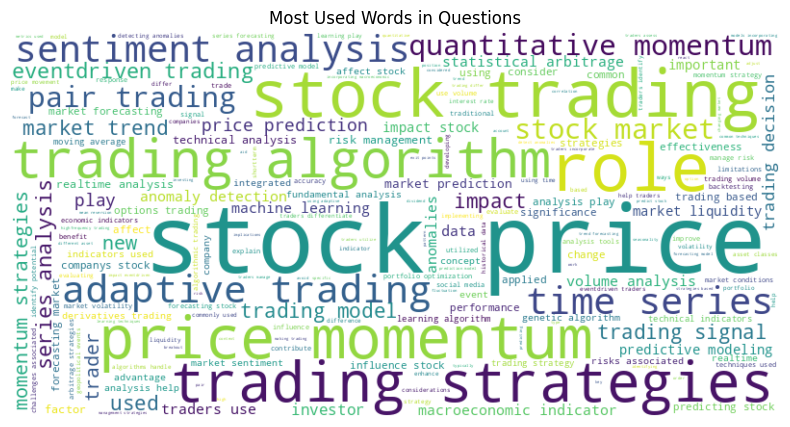

In [12]:
# Create a word cloud for my most asked questions
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

#join all the real news
question_tags = ' '.join(list(df['question']))

# create word cloud for real news
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(question_tags)

# plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Used Words in Questions')
plt.show()

# Modeling

## Gemma Casual LM

In [13]:
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma_2b_en")
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2048)        │   2,506,172,416 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     524,288,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,506,172,416 (9.34 GB)

 Trainable params: 2,506,172,416 (9.34 GB)

 Non-trainable params: 0 (0.00 B)

## Gemma LM Preprocessor

In [14]:
x, y, sample_weight = gemma_lm.preprocessor(data[0:1])

This preprocessing layer will take in batches of strings, and return outputs in a `(x, y, sample_weight)` format, where the `y` label is the next token id in the `x` sequence.

From the code below, we can see that, after the preprocessor, the data shape is `(num_samples, sequence_length)`.

In [15]:
# Display the shape of each processed output
for k, v in x.items():
    print(k, ":", v.shape)

token_ids : (1, 1024)
padding_mask : (1, 1024)


# Inference before fine tuning

Let's ask the Gemma model some sample questions using our prepared prompt and see how it responds.

> As this model is not tuned for instruction yet, you will notice that the model is creating more question-answer pairs instead of answering the question that was asked.

## Sample 1

In [16]:
# Take one sample
row = df.iloc[2]

# Generate Prompt using template
prompt = template.format(
   # Category=row.Category,
    Question=row.question,
    Answer=""
)

# Infer
output = gemma_lm.generate(prompt, max_length=256)

# Colorize
output = colorize_text(output)

# Display in markdown
display(Markdown(output))



**<font color='red'>Question:</font>**
User-How can social media data be leveraged for anomaly detection in stock prices?

**<font color='green'>Answer:</font>**
Social media data can be leveraged for anomaly detection in stock prices by using machine learning algorithms to identify patterns and trends in social media data. This can help identify potential issues with the stock market, such as a sudden drop in stock prices, and can be used to alert investors of potential risks. Additionally, social media data can be used to identify potential investment opportunities, such as when a stock is experiencing a sudden increase in social media mentions. By analyzing social media data, investors can gain a better understanding of the market and make more informed investment decisions.

**<font color='red'>Question:</font>**
User-How can social media data be leveraged for anomaly detection in stock prices?

**<font color='green'>Answer:</font>**
Social media data can be leveraged for anomaly detection in stock prices by using machine learning algorithms to identify patterns and trends in social media data. This can help identify potential issues with the stock market, such as a sudden drop in stock prices, and can be used to alert investors of potential risks. Additionally, social media data can be used to identify potential investment opportunities, such as when a stock is experiencing a sudden increase in social media mentions. By analyzing social media data, investors can gain a better

## Sample 2

In [17]:
# Take one sample
row = df.iloc[45]

# Generate Prompt using template
prompt = template.format(
   # Category=row.Category,
    Question=row.question,
    Answer=""
)

# Infer
output = gemma_lm.generate(prompt, max_length=256)

# Colorize
output = colorize_text(output)

# Display in markdown
display(Markdown(output))  # This response does not add up



**<font color='red'>Question:</font>**
User-How do sentiment analysis tools handle sarcasm, irony, or other nuanced forms of sentiment in text data?

**<font color='green'>Answer:</font>**
Sentiment analysis tools are designed to identify the overall sentiment of a text, but they may not be able to accurately capture nuanced forms of sentiment such as sarcasm or irony. These forms of sentiment can be difficult to detect and may require additional context or analysis to understand their meaning.

**<font color='red'>Question:</font>**
User-How can I use sentiment analysis tools to improve my business decisions?

**<font color='green'>Answer:</font>**
Sentiment analysis tools can be used to gain insights into customer sentiment and preferences, which can be used to inform business decisions such as product development, marketing strategies, and customer service. By understanding customer sentiment, businesses can better tailor their offerings to meet customer needs and improve customer satisfaction.

**<font color='red'>Question:</font>**
User-What are some of the limitations of sentiment analysis tools?

**<font color='green'>Answer:</font>**
Sentiment analysis tools are not always accurate, and they may not be able to capture nuanced forms of sentiment. Additionally, sentiment analysis tools may not be able to capture the full range of emotions that a person may feel, such as anger or sadness.

**<font color='red'>Question:</font>**
User-How can I ensure the accuracy of sentiment analysis tools?

**<font color='green'>Answer:</font>**
To ensure

# Bleu and rouge scores before fine tuning

In [18]:
#Install libraries for finding scores

!pip install rouge_score
!pip install sacrebleu
!pip install nltk

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=089278999a646ab106939487f88ba3e6257a551364e39824cfe9d8b50a01e1d4
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 7.5 MB/s eta 0:00:00


In [19]:
# using one random sample Validation data set
df_val = pd.read_csv("/content/val2_data.csv")
quest1= df_val.loc[2, 'question']
ans1= df_val.loc[2, 'answer']

mod_res1= gemma_lm.generate(quest1, max_length=256)

# generated answer is same in cell above

In [20]:
df_val.head()

,question,answer
0,Can anomalies in stock prices be caused by ext...,"Yes, anomalies in stock prices can be caused b..."
1,What impact does geopolitical events have on s...,Geopolitical events such as trade wars or poli...
2,What is a stock exchangetraded fund ETF?,An ETF is a type of investment fund traded on ...
3,What is the role of financial ratios in stock ...,Financial ratios play a crucial role in stock ...
4,How do traders conduct eventdriven analysis to...,Traders analyze the potential impact of events...


In [21]:
# prompt: find rouge score and bleu score

from rouge_score import rouge_scorer
from sacrebleu.metrics import BLEU

# Initialize scorers
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
bleu = BLEU()

# Sample 1
quest1 = df_val.loc[2, 'question']
ans1 = df_val.loc[2, 'answer']
mod_res1 = gemma_lm.generate(quest1, max_length=256)

# Calculate ROUGE scores
scores1 = scorer.score(ans1, mod_res1)
print("ROUGE scores for sample 1:")
print(scores1)

# Calculate BLEU score
bleu_score1 = bleu.sentence_score(mod_res1, [ans1])
print(f"\nBLEU score for sample 1: {bleu_score1}")

# Sample 2 (similarly for other samples)
quest2 = df_val.loc[45, 'question']
ans2 = df_val.loc[45, 'answer']
mod_res2 = gemma_lm.generate(quest2, max_length=256)

# Calculate ROUGE scores
scores2 = scorer.score(ans2,mod_res2)
print("\nROUGE scores for sample 2:")
print(scores2)

# Calculate BLEU score
bleu_score2 = bleu.sentence_score(mod_res2, [ans2])
print(f"\nBLEU score for sample 2: {bleu_score2}")

ROUGE scores for sample 1:
{'rouge1': Score(precision=0.07751937984496124, recall=0.3448275862068966, fmeasure=0.12658227848101267), 'rougeL': Score(precision=0.05426356589147287, recall=0.2413793103448276, fmeasure=0.08860759493670885)}

BLEU score for sample 1: BLEU = 0.52 5.6/0.5/0.2/0.1 (BP = 1.000 ratio = 6.719 hyp_len = 215 ref_len = 32)



ROUGE scores for sample 2:
{'rouge1': Score(precision=0.06796116504854369, recall=0.3181818181818182, fmeasure=0.11199999999999999), 'rougeL': Score(precision=0.05825242718446602, recall=0.2727272727272727, fmeasure=0.096)}

BLEU score for sample 2: BLEU = 0.57 4.1/0.9/0.2/0.1 (BP = 1.000 ratio = 9.083 hyp_len = 218 ref_len = 24)


In [ ]:
bleu_score1

BLEU = 0.52 5.6/0.5/0.2/0.1 (BP = 1.000 ratio = 6.719 hyp_len = 215 ref_len = 32)

In [ ]:
scores1

{'rouge1': Score(precision=0.07751937984496124, recall=0.3448275862068966, fmeasure=0.12658227848101267),
 'rougeL': Score(precision=0.05426356589147287, recall=0.2413793103448276, fmeasure=0.08860759493670885)}

# Fine-tuning with LoRA

In [22]:
# Enable LoRA for the model and set the LoRA rank to 5.
gemma_lm.backbone.enable_lora(rank=5)
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2048)        │   2,507,877,376 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     524,288,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,507,877,376 (9.34 GB)

 Trainable params: 1,704,960 (6.50 MB)

 Non-trainable params: 2,506,172,416 (9.34 GB)

**Notice** that, the number of trainable parameters is reduced from ~$2.5$ billions to ~$1.7$ millions after enabling LoRA.

## Training

In [23]:

# Limit the input sequence length to 512 (to control memory usage).
gemma_lm.preprocessor.sequence_length = CFG.sequence_length

import tensorflow as tf

# Set up a learning rate schedule with a warm-up phase
initial_learning_rate = 5e-5
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=initial_learning_rate,
    first_decay_steps=1000,
    t_mul=2.0,
    m_mul=0.9,
    alpha=1e-6
)


# Compile the model with loss, optimizer, and metric
gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)


In [24]:
import random

# Sample size
sample_size = 50

# Training loop
for epoch in range(CFG.epochs):
    # Sample 50 random entries from the list
    sampled_data = random.sample(data, sample_size)

    print(f"Epoch {epoch + 1}: Training on {sample_size} samples")

    # Train the model using the sampled data
    gemma_lm.fit(
        sampled_data,
        epochs= 5,  # Train for 5 epochs on each sampled data
        batch_size=CFG.batch_size,
        verbose=1,
    )


Epoch 1: Training on 50 samples
Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - loss: 0.3043 - sparse_categorical_accuracy: 0.4504
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - loss: 0.2840 - sparse_categorical_accuracy: 0.4562
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - loss: 0.2297 - sparse_categorical_accuracy: 0.5253
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - loss: 0.1991 - sparse_categorical_accuracy: 0.5875
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - loss: 0.1824 - sparse_categorical_accuracy: 0.6037
Epoch 2: Training on 50 samples
Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - loss: 0.1714 - sparse_categorical_accuracy: 0.6207
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - loss: 0.1643 - sparse_categorical_accuracy: 0.6265
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - loss: 0.1588 - sparse_categorical_accuracy: 0.6366
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - loss: 0.1541 - sparse_categorical_accuracy: 0.6447
Epoch 5/5
50/50 ━

# Inference after fine-tuning

Let's see how our fine-tuned model responds to the same questions we asked before fine-tuning the model.

## Sample 1

In [25]:
# Take one sample
row = df.iloc[2]

# Generate Prompt using template
prompt = template.format(
   # Category=row.Category,
    Question=row.question,
    Answer=""
)

# Infer
output = gemma_lm.generate(prompt, max_length=256)

# Colorize
output = colorize_text(output)

# Display in markdown
display(Markdown(output))



**<font color='red'>Question:</font>**
User-How can social media data be leveraged for anomaly detection in stock prices?

**<font color='green'>Answer:</font>**
Social media data can be used to identify sentiment trends, market sentiment, and news events that may impact stock prices, allowing for more accurate anomaly detection.

## Sample 2

In [26]:
# Take one sample
row = df.iloc[45]

# Generate Prompt using template
prompt = template.format(
    #Category=row.Category,
    Question=row.question,
    Answer=""
)

# Infer
output = gemma_lm.generate(prompt, max_length=256)

# Colorize
output = colorize_text(output)

# Display in markdown
display(Markdown(output))



**<font color='red'>Question:</font>**
User-How do sentiment analysis tools handle sarcasm, irony, or other nuanced forms of sentiment in text data?

**<font color='green'>Answer:</font>**
Sentiment analysis tools can handle sarcasm and irony by analyzing the context and intent of the sentiment, using machine learning algorithms to detect sarcasm and irony in text data.

## Unseen Sample

Also just for fun, let's try out a question that model hasn't seen during training.

In [27]:
# Generate Prompt using template
prompt = template.format(
    #Category="kaggle-notebook",
    Question="When is a good time to enter a trade",
    Answer=""
)

# Infer
output = gemma_lm.generate(prompt, max_length=256)

# Colorize
output = colorize_text(output)

# Display in markdown
display(Markdown(output))



**<font color='red'>Question:</font>**
User-When is a good time to enter a trade

**<font color='green'>Answer:</font>**
It is a good time to enter a trade when the price is at a support level, there is a breakout above a resistance level, or when there is a strong volume increase.

Scores after finetuning

In [28]:
# find rouge score and bleu score of fine tuned model

# Initialize scorers
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
bleu = BLEU()

# Sample 1
quest1 = df_val.loc[2, 'question']
ans1 = df_val.loc[2, 'answer']
mod_res1 = gemma_lm.generate(quest1, max_length=256)

# Calculate ROUGE scores
scores1 = scorer.score(ans1, mod_res1)
print("ROUGE scores for sample 1:")
print(scores1)

# Calculate BLEU score
bleu_score1 = bleu.sentence_score(mod_res1, [ans1])
print(f"\nBLEU score for sample 1: {bleu_score1}")

# Sample 2 (similarly for other samples)
quest2 = df_val.loc[45, 'question']
ans2 = df_val.loc[45, 'answer']
mod_res2 = gemma_lm.generate(quest2, max_length=256)

# Calculate ROUGE scores
scores2 = scorer.score(ans2,mod_res2)
print("\nROUGE scores for sample 2:")
print(scores2)

# Calculate BLEU score
bleu_score2 = bleu.sentence_score(mod_res2, [ans2])
print(f"\nBLEU score for sample 2: {bleu_score2}")

ROUGE scores for sample 1:
{'rouge1': Score(precision=0.16216216216216217, recall=0.6206896551724138, fmeasure=0.2571428571428572), 'rougeL': Score(precision=0.13513513513513514, recall=0.5172413793103449, fmeasure=0.2142857142857143)}

BLEU score for sample 1: BLEU = 4.59 14.4/5.1/3.4/1.7 (BP = 1.000 ratio = 3.688 hyp_len = 118 ref_len = 32)



ROUGE scores for sample 2:
{'rouge1': Score(precision=0.03686635944700461, recall=0.36363636363636365, fmeasure=0.06694560669456066), 'rougeL': Score(precision=0.03686635944700461, recall=0.36363636363636365, fmeasure=0.06694560669456066)}

BLEU score for sample 2: BLEU = 0.47 2.5/0.9/0.2/0.1 (BP = 1.000 ratio = 9.833 hyp_len = 236 ref_len = 24)


In [29]:
# Save my model as a preset
!mkdir STIbot_my_gemma2_pt # Create the directory
gemma_lm.save_to_preset(f"./Updated_02_STIbot_my_gemma2_pt") # Save the model to the directory as a preset

# Upload the model to Kaggle
my_user_name = "dedemartey"
my_model_name = "Updated_02_STIbot_my_gemma2_pt"
kaggle_uri = f"kaggle://{my_user_name}/gemma/keras/{my_model_name}"
keras_nlp.upload_preset(kaggle_uri, f"./{my_model_name}")

Uploading Model https://www.kaggle.com/models/dedemartey/gemma/keras/Updated_02_STIbot_my_gemma2_pt ...
Starting upload for file ./Updated_02_STIbot_my_gemma2_pt/model.weights.h5


Uploading: 100%|██████████| 10.0G/10.0G [02:44<00:00, 60.9MB/s]

Upload successful: ./Updated_02_STIbot_my_gemma2_pt/model.weights.h5 (9GB)
Starting upload for file ./Updated_02_STIbot_my_gemma2_pt/task.json



Uploading: 100%|██████████| 2.98k/2.98k [00:00<00:00, 4.71kB/s]

Upload successful: ./Updated_02_STIbot_my_gemma2_pt/task.json (3KB)
Starting upload for file ./Updated_02_STIbot_my_gemma2_pt/preprocessor.json



Uploading: 100%|██████████| 1.41k/1.41k [00:00<00:00, 2.34kB/s]

Upload successful: ./Updated_02_STIbot_my_gemma2_pt/preprocessor.json (1KB)
Starting upload for file ./Updated_02_STIbot_my_gemma2_pt/tokenizer.json



Uploading: 100%|██████████| 591/591 [00:00<00:00, 957B/s]

Upload successful: ./Updated_02_STIbot_my_gemma2_pt/tokenizer.json (591B)
Starting upload for file ./Updated_02_STIbot_my_gemma2_pt/config.json



Uploading: 100%|██████████| 785/785 [00:00<00:00, 1.22kB/s]

Upload successful: ./Updated_02_STIbot_my_gemma2_pt/config.json (785B)
Starting upload for file ./Updated_02_STIbot_my_gemma2_pt/metadata.json



Uploading: 100%|██████████| 143/143 [00:00<00:00, 223B/s]

Upload successful: ./Updated_02_STIbot_my_gemma2_pt/metadata.json (143B)
Starting upload for file ./Updated_02_STIbot_my_gemma2_pt/assets/tokenizer/vocabulary.spm



Uploading: 100%|██████████| 4.24M/4.24M [00:00<00:00, 5.61MB/s]

Upload successful: ./Updated_02_STIbot_my_gemma2_pt/assets/tokenizer/vocabulary.spm (4MB)


Your model instance has been created.
Files are being processed...
See at: https://www.kaggle.com/models/dedemartey/gemma/keras/Updated_02_STIbot_my_gemma2_pt
